## Successfully Replicated Matlab Results!

In [2]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pywt
import cv2
from skimage.draw import polygon2mask
from skimage.measure import find_contours
import pywt
from matplotlib.colors import LogNorm
import math
import scipy.signal
from scipy.stats import mstats

In [2]:
def get_ttl_trace(timestamps_table, timestamps_table_names, timeorigin, timebinning=1):
    """
    Extracts the TTL trace from the movie specs.

    Args:
    - timestamps_table (np.ndarray): Timestamps table containing TTL data.
    - timestamps_table_names (np.ndarray): Column names for the timestamps table.
    - timeorigin (int): Starting index for the TTL signal.
    - timebinning (int, optional): Time binning factor for downsampling (default: 1).

    Returns:
    - np.ndarray: Extracted TTL signal.
    """
  
    # Get the column index for 'behavior_ttl'
    ttl_column = timestamps_table_names.index("behavior_ttl")

    # Extract the raw TTL signal starting from `timeorigin`
    ttl_signal_raw = timestamps_table[ttl_column, int(timeorigin):]

    # Apply binning if `timebinning` is greater than 1
    if timebinning > 1:
        # Ensure the length of ttl_signal_raw is divisible by timebinning
        trimmed_length = len(ttl_signal_raw) - (len(ttl_signal_raw) % timebinning)
        ttl_signal_raw = ttl_signal_raw[:trimmed_length]
        
        # Reshape, average over bins, and round the result
        ttl_signal = np.round(np.mean(ttl_signal_raw.reshape(-1, timebinning), axis=1))
    else:
        ttl_signal = ttl_signal_raw

    onsets = np.where(np.diff(ttl_signal) == 1)[0] 
    offsets = np.where(np.diff(ttl_signal) == -1)[0] 

    return onsets, offsets

In [3]:
def movie_path(mouse, date, file):
    """Returns the file path for a given movie recording."""
    return "N:/GEVI_Wave/Analysis/Visual/" + mouse + "/20" + str(date) + "/" + file + '/cG_unmixed_dFF.h5'

def mask_movie(movie, raw_mask, binning):
    """
    Applies a spatial mask to a movie to exclude non-brain regions.

    Args:
    - movie (numpy.ndarray): 3D array representing the movie (t, x, y).
    - raw_mask (numpy.ndarray): 2D mask array.
    - binning (float): Scaling factor for resizing the mask.

    Returns:
    - numpy.ndarray: The masked movie with non-brain regions removed.
    """
    # Resize the mask using bilinear interpolation
    mask = cv2.resize(raw_mask, (0, 0), fx=1/binning, fy=1/binning, interpolation=cv2.INTER_LINEAR)
    
    # Ensure mask has the same shape as the movie
    movie_size = movie.shape[1:3]  # Get spatial dimensions of the movie
    mask = mask[:movie_size[0], :movie_size[1]]  # Crop mask to match movie size
    mask = np.flip(mask, axis=0)
    mask = mask.astype(bool)         # Convert to boolean mask
    return movie * mask  # Apply mask

def mask_region(movie, raw_outlines, binning, spaceorigin, region, plot=False):
    """
    Applies a mask to a movie based on anatomical brain region outlines.

    Args:
    - movie (numpy.ndarray): 3D movie array (t, x, y).
    - raw_outlines (numpy.ndarray): 3D array of brain region outlines.
    - binning (float): Scaling factor for spatial binning.
    - spaceorigin (numpy.ndarray): 2D array of space origin coordinates.
    - region (str): Brain region to mask ('V1' or 'SSC').
    - plot (bool, optional): Whether to display the mask overlay on the first frame of the movie.

    Returns:
    - numpy.ndarray: The masked movie where only the selected region remains.
    """

    # Define the corresponding outline indices for the selected brain region
    if region == 'V1':
        indices=[37]
    elif region == 'SSC':
        indices=[3,11,13,15]
    else:
        print('Region must be V1 or SSC')

    spaceorigin = (spaceorigin - 1) / binning + 1  # Apply space origin transformation

    # Extract all outlines and scale them according to binning
    outlines_nums = np.arange(raw_outlines.shape[2]) 
    outlines = raw_outlines[:, :, outlines_nums] / binning

    outlines[:, 0, :] -= spaceorigin[1] - 1  # Adjust Y-coordinates
    outlines[:, 1, :] -= spaceorigin[0] - 1  # Adjust X-coordinates

    # Define the movie dimensions
    movie_shape = movie.shape[1:3]  # (height, width)
            
    if plot:
    # Plot the first movie frame
        plt.figure(figsize=(6, 6))
        plt.imshow(movie[0])  # Display movie frame
        plt.title(f"Movie with {region} Outline")

    total_mask = np.zeros(movie_shape, dtype=bool)

    for i in indices:
        # Extract the ROI outline
        outline = outlines[i, :, :]  # Shape (2, N)

        valid_indices = ~np.isnan(outline).any(axis=0)  # Find non-NaN indices
        x_coords = outline[1, valid_indices]
        y_coords = outline[0, valid_indices]

        # Create a mask using polygon2mask
        roi_mask = polygon2mask(movie_shape, np.column_stack((y_coords, x_coords)))
        roi_mask = np.flipud(roi_mask).astype(bool)
        total_mask |= roi_mask  # Any pixel belonging to at least one ROI remains unmasked

    # Apply mask to the movie
    movie_roi = movie * total_mask  # Broadcasting applies the mask to all frames

    # Find contours of the ROI mask
    contours = find_contours(total_mask, level=0.5)  # Extract the outline

    if plot:
        # Overlay the mask outline
        for contour in contours:
            plt.plot(contour[:, 1], contour[:, 0], color='red', linewidth=1.5)  # Plot contour in red
    plt.show()

    return movie_roi

def load_and_mask(path_movie):
    """
    Loads a movie file, applies masking, and optionally extracts a specific brain region.

    Args:
    - mouse (str): Mouse identifier.
    - date (str or int): Experiment date in YYMMDD format.
    - file (str): Recording file identifier.
    - region (str, optional): Brain region to isolate ('V1' or 'SSC'). If None, the full movie is returned.

    Returns:
    - movie (numpy.ndarray): 3D array (t, x, y) representing the processed movie.
    - fps (float): Frames per second of the movie.
    """

    with h5py.File(path_movie, 'r') as mov_file:
        specs = mov_file["specs"]
        mov = mov_file['mov'][()]  
        fps = specs["fps"][()][0][0][0]  
        raw_mask = specs["extra_specs"]["mask"][()]
        binning = specs["binning"][()][0][0][0]
        raw_outlines = specs["extra_specs"]["allenMapEdgeOutline"][()]
        spaceorigin = specs["spaceorigin"][()].flatten()  

        timeorigin = specs["timeorigin"][()][0][0][0]
        timebinning = specs["timebinning"][()][0][0]
        timestamps_table = specs["extra_specs"]["timestamps_table"][()].squeeze()
        timestamps_table_names = specs["extra_specs"]["timestamps_table_names"][()]
        timestamps_table_names = b''.join(timestamps_table_names.flatten()).decode("utf-8").split(';')

    onsets, offsets = get_ttl_trace(timestamps_table, timestamps_table_names, timeorigin, timebinning)

    # Replace NaN values in the movie
    movie = np.nan_to_num(mov)
    movie = np.flip(movie, axis=1)

    # Apply the brain mask to remove non-brain regions
    movie = mask_movie(movie, raw_mask, binning)

    # If a specific brain region is provided, apply the corresponding region mask
    movie = mask_region(movie, raw_outlines, binning, spaceorigin, 'V1', plot=True)

    return movie, fps, onsets, offsets

In [4]:
path_movie = "N:/GEVI_Wave/Analysis/Visual/cmm002mjr/20231208/meas00/cG_unmixed_dFF.h5"

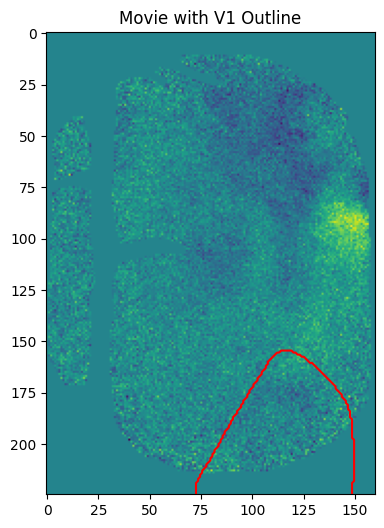

np.float64(157.18327569957034)

In [5]:
movie, fps, onsets, offsets = load_and_mask(path_movie)
fps

In [6]:
def spectrogram(segment, fps, f_range=(2, 60), num_freqs=100):
    """
    Compute a wavelet spectrogram of a signal segment using MATLAB-matching parameters.
    
    Parameters:
        segment: 1D numpy array (signal trace for a single trial)
        fps: frames per second (sampling rate)
        f_range: frequency range (Hz)
        num_freqs: number of frequency bins (log spaced)
        time_bandwidth: MATLAB-like 'TimeBandwidth' parameter
        voices_per_octave: MATLAB-like 'VoicesPerOctave' parameter

    Returns:
        power: normalized wavelet magnitude (freq x time)
        freqs: corresponding frequencies in Hz
    """
    dt = 1 / fps
    freqs = np.logspace(np.log10(f_range[0]), np.log10(f_range[1]), num_freqs)
    
    # Morelet wavelet
    wavelet = 'cmor2.0-1.0'
    
    # Match MATLAB scale construction
    scales = pywt.scale2frequency(wavelet, 1.0) / freqs * fps

    # Compute wavelet transform
    coeffs, actual_freqs = pywt.cwt(segment, scales, wavelet, sampling_period=dt)
    
    # Normalize as MATLAB: abs(wt) / sqrt(freq)
    amplitude = np.abs(coeffs) / np.sqrt(actual_freqs[:, np.newaxis])
    
    return amplitude, actual_freqs

def trial_averaged_spectrogram(
    trace, fps, stim_onsets, stim_offsets,
    pre_window=2.0, post_window=4.0,
    align_to='offset', f_range=(2, 60),
    quantile_norm=True, plot=True
):
    """
    Create a trial-averaged spectrogram aligned to stimulus onsets or offsets.
    
    Parameters:
        trace: 1D numpy array (full signal)
        fps: sampling rate (Hz)
        stim_onsets: array of stimulus onset indices (in frames)
        stim_offsets: array of stimulus offset indices (in frames)
        pre_window, post_window: seconds before/after alignment
        align_to: 'onset' or 'offset'
        f_range: tuple of frequency limits (Hz)
        quantile_norm: if True, apply (wt - q01) / q10 per freq
        plot: whether to display spectrogram

    Returns:
        wt_plot: trial-averaged normalized spectrogram
        time_axis: time vector in seconds
        freqs: frequency vector in Hz
    """
    assert align_to in ['onset', 'offset'], "align_to must be 'onset' or 'offset'"
    align_frames = stim_onsets if align_to == 'onset' else stim_offsets

    pre_frames = int(pre_window * fps)
    post_frames = int(post_window * fps)
    trial_len = pre_frames + post_frames

    # Compute spectrogram for each aligned trial
    trial_spectrograms = []
    for align in align_frames:
        start = align - pre_frames
        end = align + post_frames
        if start < 0 or end > len(trace):
            continue
        segment = trace[start:end]
        power, freqs = spectrogram(segment, fps, f_range)
        trial_spectrograms.append(power)

    trial_spectrograms = np.stack(trial_spectrograms, axis=0)  # (n_trials, n_freqs, n_time)
    mean_spectrogram = np.nanmean(trial_spectrograms, axis=0)  # (freqs x time)

    # Quantile normalization like MATLAB
    q01 = np.quantile(mean_spectrogram, 0.01, axis=1, keepdims=True)
    q10 = np.quantile(mean_spectrogram, 0.10, axis=1, keepdims=True)
    wt_plot = (mean_spectrogram - q01) / (q10 + 1e-10) * 100

    # Time axis in seconds, aligned at t=0
    time_axis = np.linspace(-pre_window, post_window, trial_len)

    if plot:
        fig, ax = plt.subplots(figsize=(8, 5))
        cs = np.quantile(wt_plot, [0.01, 0.95])
        pcm = ax.pcolormesh(time_axis, freqs, wt_plot, shading='auto', cmap='jet')
        pcm.set_clim(cs[0], cs[1])
        cb = fig.colorbar(pcm, ax=ax)
        cb.set_label("Change of wavelet magnitude (%)", fontsize=12)
        ax.set_xlabel(f"Time relative to stimulus {align_to} (s)", fontsize=12)
        ax.set_ylabel("Frequency (Hz)", fontsize=12)
        ax.set_ylim(f_range)
        ax.set_title(f"Trial-Averaged Wavelet Spectrogram (aligned to {align_to})", fontsize=13)
        plt.tight_layout()

    return wt_plot, time_axis, freqs

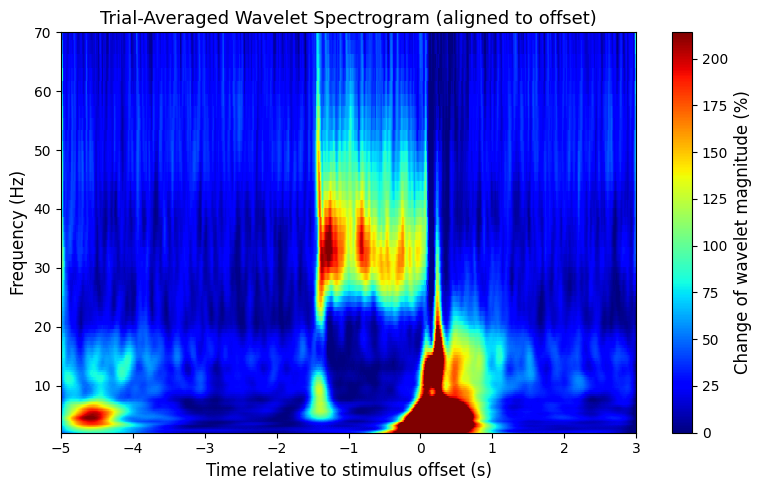

In [8]:
movie_trace = np.mean(movie, axis=(1,2))
_, _, _ = trial_averaged_spectrogram(movie_trace, fps, onsets, offsets, align_to='offset', pre_window=5, post_window=3, f_range=(2, 70))